
## Projections of Ensemble Species Distribution Models: Assessing Climate Change Impacts on a Pair of Symbiotic Species

*How can models of climate change effects on geographic distributions incorporate symbiotic species relationships? What is the best quantification of uncertainty for climate forecasts in Southwestern deserts?*

---

**Author : [Daniel Furman](mailto:dryanfurman@gmail.com)** **|** Harvey Mudd College **|** NSF Award (#1757952)

---

Scripts for reproducing analyses presented at SICB 2021 and SCCUR 2019 conferences. The notebook is contained within a [GitHub Repository](https://github.com/daniel-furman/ensemble-climate-projections) alongside its accompanying files and data.

### Comparing ML Classifiers with PyCaret and SKlearn
---

**Description for features is as follows :**

|Variable|	Definition|	Units|   
|:---  |:--- |:---|
|BioClim12| Annual Precipitation | mm
|BioClim14| Precip Driest Month| mm
|BioClim15| Precip Seasonality (coefficient of variation)| n/a
|BioClim18| Precip Warmest Quarter | mm
|BioClim19| Precip Coldest Quareter| mm
|BioClim3| Isothermality | $^o$C*100
|BioClim6| Min Temp Coldest Month| $^o$C
|BioClim7| Temp Annual Range| $^o$C
|BioClim8| Mean Temp Wettest Quareter | $^o$C
|BioClim9| Mean Temp Driest Quareter | $^o$C

**Description for the target variable is as follows :**

|Variable|	Definition|	Units|   
|:---  |:--- |:---|
|Pa| Binary class | 1 (presence) & 0 (background)

---
 
Binary classification is performed with ten BioClim features, five of which are a function of precipitation and five of temperature. The features were decorrelated below a 0.5 correlation threshold through jacknife resample testing. We use PyCaret to train and tune (10-fold cv) our models from a train set that contains 80% of the total data. Raster processing, data extraction, train/test splitting, as well as data piping to .csv and geojson were performed in R.

---

In [2]:
exec(open('ML_sdms_train.py').read())

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.8766,0.9451,0.8767,0.8777,0.8765,0.7532,0.7544,0.0600
rf,Random Forest Classifier,0.8758,0.9450,0.8760,0.8776,0.8757,0.7517,0.7534,0.3530
catboost,CatBoost Classifier,0.8736,0.9461,0.8738,0.8771,0.8733,0.7473,0.7507,1.8520
et,Extra Trees Classifier,0.8721,0.9480,0.8722,0.8731,0.8720,0.7442,0.7452,0.2970
gbc,Gradient Boosting Classifier,0.8698,0.9384,0.8700,0.8724,0.8696,0.7397,0.7423,0.1570
xgboost,Extreme Gradient Boosting,0.8683,0.9448,0.8684,0.8699,0.8682,0.7367,0.7382,0.1630
ada,Ada Boost Classifier,0.8352,0.9069,0.8354,0.8381,0.8349,0.6705,0.6733,0.0700
dt,Decision Tree Classifier,0.8300,0.8311,0.8301,0.8311,0.8298,0.6600,0.6611,0.0120
qda,Quadratic Discriminant Analysis,0.8157,0.8991,0.8161,0.8238,0.8146,0.6316,0.6395,0.0140
knn,K Neighbors Classifier,0.8006,0.8742,0.8010,0.8076,0.7995,0.6016,0.6084,0.0750


---

Now that we have trained and tuned our ML models, we are ready to test their validation set performance. We first print the validation F statistic and 2x2 confusion matrix and then visualize the AUC statistic with the ROC curve. A blended model was also created with the five most predictive PyCaret classifiers, which will be used for the ensemle climate projections. Lastly, we rank our models by the validation F statistic. 

---

Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded


Fraction correct validation 5-model Blend : 0.8881856540084389
[[211  26]
 [ 27 210]]
The F1 validation score is :  0.8879492600422833


Fraction correct validation Random Forest : 0.8987341772151899
[[215  22]
 [ 26 211]]
The F1 validation score is :  0.897872340425532


Fraction correct validation Extra Trees : 0.8945147679324894
[[212  25]
 [ 25 212]]
The F1 validation score is :  0.8945147679324894


Fraction correct validation XGBoost : 0.8860759493670886
[[209  28]
 [ 26 211]]
The F1 validation score is :  0.8865546218487396


Fraction correct validation LGBoost Machine : 0.8734177215189873
[[206  31]
 [ 29 208]]
The F1 validation score is :  0.873949579831932

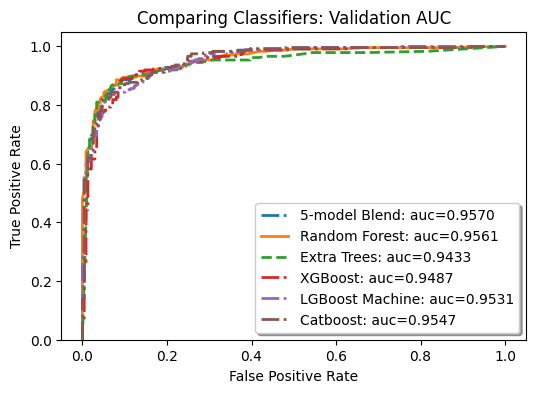

In [3]:
exec(open('ML_sdms_predict.py').read())

In [4]:
f_score # from validation set

,Random Forest,Extra Trees,5-model Blend,XGBoost,Catboost,LGBoost Machine
F-statistic :,0.897872,0.894515,0.887949,0.886555,0.875789,0.87395


### Geospatial Predictions of Species Distributions

---

We first perform spatial classification with the 5-model blended classifier. Spatial predictions were powered by the pyimpute library, see my [contributions](https://github.com/perrygeo/pyimpute/pull/21) merged at version 0.2 (_main.py). We also perform a spatial blend of the five models. In the next notebook, we perform a series of climate projections with 8 unique climate models over 16 different future scenarios. 

In [5]:
# directly define edited pyimpute functions
exec(open('_main.py').read())
# or import pyimpute>=0.2
from pyimpute import load_training_vector
from pyimpute import load_targets
from pyimpute import impute

In [7]:
import glob 
import geopandas as gpd
import rasterio
import matplotlib.pyplot as plt
# grab features
explanatory_rasters = sorted(glob.glob(
    '/Users/danielfurman/Data_science_code/xantusia-codebase/data/train-rasters-2.5m/bclim*.asc'))

print('\nThere are', len(explanatory_rasters), '.asc features.') # check there are ten 
# grab shapefile containing 100% of the final presence/absence locations
response_data = gpd.GeoDataFrame.from_file(
    '/Users/danielfurman/Data_science_code/xantusia-codebase/data/geofile-xv-presences/xv.shp') 
response_data.head(3) # check geopandas data 


There are 10 .asc features.


,CLASS,Id,geometry
0,1.0,GBIF - Id 1145647218,POINT (-121.19754 36.45238)
1,1.0,GBIF - Id 1888930558,POINT (-115.14170 36.05382)
2,0.0,Bckgrd - Id 683,POINT (-117.81250 34.35417)


In [8]:
print("number of duplicates: ", response_data.duplicated(subset='geometry', keep='first').sum())
print("number of NA's: ", response_data['geometry'].isna().sum())
print("Coordinate reference system is: {}".format(response_data.crs))
print("{} observations with {} columns".format(*response_data.shape))

number of duplicates:  0
number of NA's:  0
Coordinate reference system is: epsg:4326
2374 observations with 3 columns


In [9]:
# create pyimpute framework
train_xs, train_y = load_training_vector(response_data,
                                         explanatory_rasters,
                                         response_field='CLASS') 
train_xs.shape, train_y.shape # check shape

((2374, 10), (2374,))

In [10]:
# first make spatial prediction with the 5-model blended classifier
target_xs, raster_info = load_targets(explanatory_rasters)
blender_specific.fit(train_xs, train_y)
# spatial prediction with impute function, saves tifs to file
session_number = '3'
os.mkdir('/Users/danielfurman/Data_science_code/xantusia-codebase/outputs' + session_number)
os.mkdir('/Users/danielfurman/Data_science_code/xantusia-codebase/outputs'
         + session_number + '/blender-baseline')
impute(target_xs, blender_specific, raster_info, 
       outdir='/Users/danielfurman/Data_science_code/xantusia-codebase/outputs'
        + session_number + '/blender-baseline', class_prob=True, certainty=True)

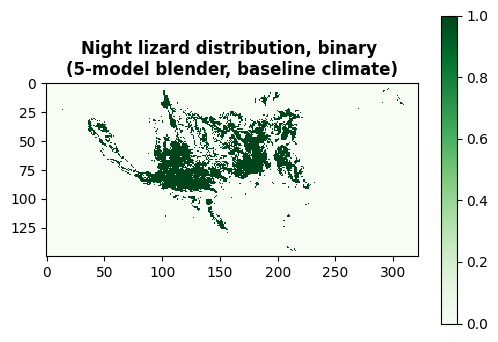

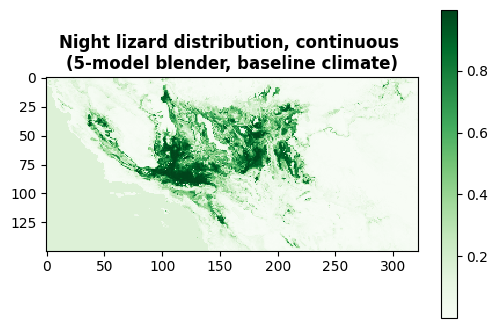

In [11]:
# plot the spatial output of the 5-model blended classifier
from pylab import plt
# define spatial plotter
def plotit(x, title, cmap="Blues"):
    plt.imshow(x, cmap=cmap, interpolation='nearest')
    plt.colorbar()
    plt.title(title, fontweight = 'bold')
    
blended_curr = rasterio.open('/Users/danielfurman/Data_science_code/xantusia-codebase/outputs'
         + session_number + '/blender-baseline/responses.tif')

plotit(blended_curr.read(1),'Night lizard distribution, binary \n(5-model blender, baseline climate)',
        cmap='Greens')
plt.figure()
blended_curr = rasterio.open('/Users/danielfurman/Data_science_code/xantusia-codebase/outputs'
         + session_number + '/blender-baseline/probability_1.0.tif') 
plotit(blended_curr.read(1),'Night lizard distribution, continuous \n(5-model blender, baseline climate)',
        cmap='Greens')

print('')

In [12]:
# Now perform a 5-model spatial blend, averaging the five individual model's spatial outputs

CLASS_MAP = {
    'rf': (rf),
    'et': (etrees),
    'xgb': (xgboost),
    'lgbm': (lgbm),
    'cb': (catboost)
    }

for name, (model) in CLASS_MAP.items():
    # Cross val for accuracy scores (as a %) for the entirety of the presence/background database
    k = 5 # k-fold
    kf = model_selection.KFold(n_splits=k)
    accuracy_scores = model_selection.cross_val_score(model, train_xs, train_y, cv=kf, scoring='accuracy')
    print(name + " %d-fold Cross Validation Accuracy: %0.2f (+/- %0.2f)"
          % (k, accuracy_scores.mean() * 100, accuracy_scores.std() * 200))
    
    # spatial prediction
    model.fit(train_xs, train_y)
    os.mkdir('/Users/danielfurman/Data_science_code/xantusia-codebase/outputs'
         + session_number + '/' + name + '-baseline')
    impute(target_xs, model, raster_info, outdir='/Users/danielfurman/Data_science_code/xantusia-codebase/outputs'
         + session_number + '/' + name + '-baseline', class_prob=True, certainty=True)

rf 5-fold Cross Validation Accuracy: 88.84 (+/- 3.01)
et 5-fold Cross Validation Accuracy: 89.68 (+/- 2.62)
xgb 5-fold Cross Validation Accuracy: 88.29 (+/- 3.13)
lgbm 5-fold Cross Validation Accuracy: 88.42 (+/- 2.09)
cb 5-fold Cross Validation Accuracy: 88.75 (+/- 2.96)


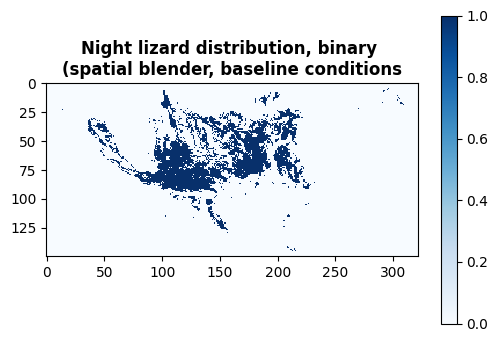

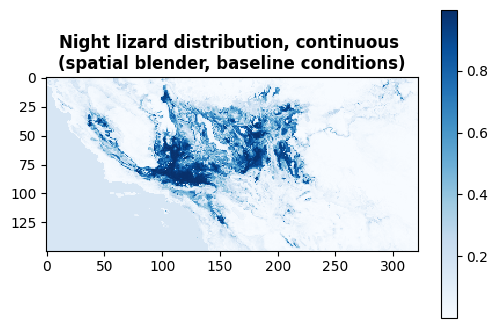

In [13]:
# import rasterio
distr_rf = rasterio.open(
    '/Users/danielfurman/Data_science_code/xantusia-codebase/outputs'
         + session_number + '/rf-baseline/probability_1.0.tif').read(1)
distr_et = rasterio.open(
    '/Users/danielfurman/Data_science_code/xantusia-codebase/outputs'
         + session_number + '/et-baseline/probability_1.0.tif').read(1)
distr_xgb =  rasterio.open(
    '/Users/danielfurman/Data_science_code/xantusia-codebase/outputs'
         + session_number + '/xgb-baseline/probability_1.0.tif').read(1)
distr_lgbm =  rasterio.open(
    '/Users/danielfurman/Data_science_code/xantusia-codebase/outputs'
         + session_number + '/lgbm-baseline/probability_1.0.tif').read(1)
distr_cb =  rasterio.open(
    '/Users/danielfurman/Data_science_code/xantusia-codebase/outputs'
         + session_number + '/cb-baseline/probability_1.0.tif').read(1)

spatial_blend = (distr_rf + distr_et + distr_xgb + distr_lgbm + distr_cb)/5  

plotit(spatial_blend > 0.5, 'Night lizard distribution, binary \n(spatial blender, baseline conditions')
plt.figure()
plotit(spatial_blend, 'Night lizard distribution, continuous \n(spatial blender, baseline conditions)')
print('')